In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
#%matplotlib qt   # doesn't work on my laptop
from tistools import read_inputfile, get_LMR_interfaces, read_pathensemble, get_weights
from tistools import set_tau_distrib, set_tau_first_hit_M_distrib, cross_dist_distr, pathlength_distr
from tistools import collect_tau, collect_tau1, collect_tau2, collect_taum
from tistools import ACCFLAGS, REJFLAGS

from tistools import get_lmr_masks, get_generation_mask, get_flag_mask
from tistools import unwrap_by_weight, running_avg_local_probs, get_local_probs, get_globall_probs, get_global_probz

from pprint import pprint    # to print the vars of the pathensemble object

In [3]:
%autoreload 2   # something with pip install -e .

UsageError: unrecognized arguments: # something with pip install -e .


# Reading

In [58]:
# zero_minus_one = True if lambda_-1 interface is set
# zero_minus_one = False if lambda_-1 interface is not set

# data the maze
#---------------
indir = "/Users/an/Documents/0_mfpt/repptis1/"
zero_minus_one = True
inputfile = indir + "/out.rst"
#inputfile = indir + "/retis.rst"

# new data Elias
#---------------
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/brownian-gamma5/30k-cycles/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/langevin-gamma5/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbump1-walls/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbump2-walls/langevin-gamma5/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbump3-walls/langevin-gamma5/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbump3-walls/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/REPPTIS"
indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbumpmeta-walls/brownian/corr/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbumpmeta-walls/langevin_gamma5/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbumpmeta-walls/brownian/fine_intf/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbumpmeta-walls/langevin_gamma5/fine_intf/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbumpmeta-walls/brownian/intf_shift/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbumpmeta-walls/langevin_gamma5/intf_shift/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdipmeta-walls/brownian/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdipmeta-walls/langevin_gamma5/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar0_restruc2"
zero_minus_one = False
inputfile = indir + "/repptis.rst"

import os
import glob
os.chdir(indir)
print(os.getcwd())


folders = glob.glob(indir + "/0[0-9][0-9]")
folders = sorted(folders)
print(folders)

/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS
['/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/000', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/001', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/002', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/003', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/004']


In [61]:
# !!! last lines !!!  allow to speed up this notebook
# pe.set_orders(load=False...)  -> 1st time you run the code, this will store npy files
# pe.set_orders(load=True...)  -> next time you run the code, you can read npy files

# Reading all input
#===================
interfaces, zero_left, timestep = read_inputfile(inputfile)
LMR_interfaces, LMR_strings = get_LMR_interfaces(interfaces, zero_left)
pathensembles = []
for i,fol in enumerate(folders):
    print("#"*80)
    print(fol)
    pe = read_pathensemble(fol+"/pathensemble.txt")
    pe.set_name(fol)
    pe.set_interfaces([LMR_interfaces[i], LMR_strings[i]])
    if i==0:
        pe.set_zero_minus_one(zero_minus_one)   # TODO this is never used
        pe.set_in_zero_minus(True)
    if i==1:
        pe.set_in_zero_plus(True)
    w, _ = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
    pe.set_weights(w)
    print("pathensemble info: ")
    pprint(vars(pe))
    pathensembles.append(pe)
    # read order parameters order.txt/order.npy into path ensemble object
    #pe.set_orders(load=False, acc_only=True, save=False) # if saving doesn't work
    #### CHANGE HERE ####
    pe.set_orders(load=False, acc_only=True, save=True) # for the 1st time
    # pe.set_orders(load=True, acc_only=True) # for the next times, save=True/False is not important

################################################################################
/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/000
pathensemble info: 
{'cyclenumbers': array([    0,     1,     2, ..., 29998, 29999, 30000]),
 'flags': array(['ACC', 'ACC', 'ACC', ..., 'ACC', 'ACC', 'FTL'], dtype='<U3'),
 'generation': array(['ki', 'sh', 'sh', ..., 'sh', 'sh', 'sh'], dtype='<U2'),
 'has_zero_minus_one': False,
 'in_zero_minus': True,
 'in_zero_plus': False,
 'interfaces': [[-0.1, -0.1, -0.1], ['l_[0]', 'l_[0]', 'l_[0]']],
 'lambmaxs': array([-0.0998876 , -0.09985364, -0.09985525, ..., -0.09986862,
       -0.09989728, -0.09993027]),
 'lambmins': array([-0.39183776, -0.39233455, -0.29408372, ..., -0.3112005 ,
       -0.17319789, -0.3284618 ]),
 'lengths': array([3189, 4157, 3533, ..., 4829, 3106, 8881]),
 'lmrs': array(['RMR', 'RMR', 'RMR', ..., 'RMR', 'RMR', 'RM*'], dtype='<U3'),
 'name': '/mnt/0bf0c339-34bb-4500-a5fb-f3

# Analysis

In [62]:
# Setting path ensemble properties
#==================================
for i,fol in enumerate(folders):
    print(i)
    print("Calculating path lengths.")
    set_tau_distrib(pathensembles[i])
    print("Done.")

    if True:
        print("Calculating first hitting lengths to middle interface")
        set_tau_first_hit_M_distrib(pathensembles[i])
        print("Done.")

0
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
Done.
1
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
Done.
2
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
Done.
3
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
Done.
4
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
Done.


In [63]:
# Analyze the pptis simulation.
# Analysis output is saved to the data dictionary.
data = {}
for i, pe in enumerate(pathensembles):
    print("doing pathensemble {}".format(i))
    if i == 0:
        data[i] = {}
        continue  # TODO: make [0-] analysis ???

    # masks - TODO not used further on?
    # TODO these functions are duplicate in repptis_analysis
    #masks = get_lmr_masks(pe)
    #loadmask = get_generation_mask(pe, "ld")
    #print("Amount of loads: {}".format(np.sum(loadmask)))
    ##hardloadmask = get_hard_load_mask(loadmask)
    #accmask = get_flag_mask(pe, "ACC")

    # pathtype_cycles
    pathtypes = ("LML", "LMR", "RML", "RMR")
    pathtype_cycles = {}
    for ptype in pathtypes:
        pathtype_cycles[ptype] = unwrap_by_weight(
                (pe.lmrs == ptype).astype(int), pe.weights)
    
    # running average analysis: ["running"]
    data[i] = {}
    data[i]["running"] = {}
    data[i]["running"]["plocal"] = {}
    # you'll still have to hardload select pe.weigths... TODO. # this is comment wouter?
    for (ptype, p_loc) in zip(pathtypes, 
                              running_avg_local_probs(pathtype_cycles, 
                                                      pe.weights, tr = False)):
        data[i]["running"]["plocal"][ptype] = p_loc

    # analysis using all data: ["full"]
    plocfull = get_local_probs(pe, tr=False)
    data[i]["full"] = {}
    for ptype in pathtypes:
        data[i]["full"][ptype] = plocfull[ptype]

    # data[i] have now ["full"] and ["running"]

doing pathensemble 0
doing pathensemble 1
Weights of the different paths:
wRMR = 0
wRML = 14125
wLMR = 14834
wLML = 1042
Local crossing probabilities:
pRMR = 0.0
pRML = 1.0
pLMR = 0.9343663391282439
pLML = 0.06563366087175611
Local crossing probabilities:
p2R = 0.49445018499383353
p2L = 0.5055498150061665
doing pathensemble 2
Weights of the different paths:
wRMR = 4370
wRML = 10698
wLMR = 10864
wLML = 4069
Local crossing probabilities:
pRMR = 0.29001858242633394
pRML = 0.7099814175736661
pLMR = 0.7275162392017679
pLML = 0.2724837607982321
Local crossing probabilities:
p2R = 0.5077830738975367
p2L = 0.49221692610246326
doing pathensemble 3
Weights of the different paths:
wRMR = 692
wRML = 14309
wLMR = 14320
wLML = 675
Local crossing probabilities:
pRMR = 0.04613025798280115
pRML = 0.9538697420171989
pLMR = 0.9549849949983328
pLML = 0.045015005001667226
Local crossing probabilities:
p2R = 0.5004667288971862
p2L = 0.4995332711028137
doing pathensemble 4
Weights of the different paths:
wRM

/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/tistools/repptis_analysis.py:555: RuntimeWarning: invalid value encountered in divide
  p_PP = cumsums['RMR']/(cumsums['RML']+cumsums['RMR'])
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/tistools/repptis_analysis.py:556: RuntimeWarning: invalid value encountered in divide
  p_PN = cumsums['RML']/(cumsums['RML']+cumsums['RMR'])


In [64]:

for i, pe in enumerate(pathensembles):
    upe = pe.unify_pe()
    # Pathlength distribution
    data[i]["pathlengths"] = pathlength_distr(upe)  # these might be used later or not! TODO
        
#=======================================
# make figures
makefigs = True 
if makefigs:
    for i, pe in enumerate(pathensembles):     
        if i == 0:
            continue
        # Cross distances distribution
        L, M, R, lmlpercs, lmllambs, rmrpercs, rmrlambs = cross_dist_distr(pe)
        fig,ax = plt.subplots()
        ax.plot(lmllambs, lmlpercs, lw=1, c="g")
        ax.plot(rmrlambs, rmrpercs, lw=1, c="r")
        for lamb in (L,M,R):
            ax.axvline(lamb, color='k', linestyle='--', lw = 0.5)
        ax.set_xlabel('Cross distance')
        ax.set_ylabel('Frequency')
        ax.set_title("Ensemble {}. L = {}, M = {}, R = {}".format(
            pe.name, L, M, R))
        ax.set_ylim(0)
        fig.savefig(f"pathensemble_{i}_crossdist.pdf")
        plt.close(fig)

        # Pathlength distribution      
        for ptype in pathtypes:
            fig, ax = plt.subplots()
            ax.plot(data[i]["pathlengths"][ptype]["bin_centers"], 
                data[i]["pathlengths"][ptype]["hist"])
            ax.set_xlabel('Pathlength')
            ax.set_ylabel('Frequency')
            ax.set_title(f"{np.sum(data[i]['pathlengths'][ptype]['hist'])} " + \
                         f"{ptype} paths. ")
            ax.legend([f"mean = {data[i]['pathlengths'][ptype]['mean']:.2f}, " + \
                          f"std = {data[i]['pathlengths'][ptype]['std']:.2f}"])
            fig.savefig(f"pathensemble_{i}_pathlength_{ptype}.pdf")
            plt.close(fig)

Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True


/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Pcross with recursive relations

In [65]:
# Global crossing probabilities
# WITHOUT ERRORS #  
# Full data 
psfull = []
for i in range(1, len(pathensembles)):   # do not use the 0- ensemble
    psfull.append({"LMR": data[i]["full"]["LMR"], 
               "RML": data[i]["full"]["RML"], 
               "RMR": data[i]["full"]["RMR"],
               "LML": data[i]["full"]["LML"]})

Pminfull, Pplusfull, Pcrossfull = get_globall_probs(psfull)

This should be the same as the repptis_report.pdf value: 0.525090186363009
which is the case!
Here, the load immediately disappeared. For a simulation where this is
not the case, the above code should be adapted a little bit.


/tmp/ipykernel_9450/878040726.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


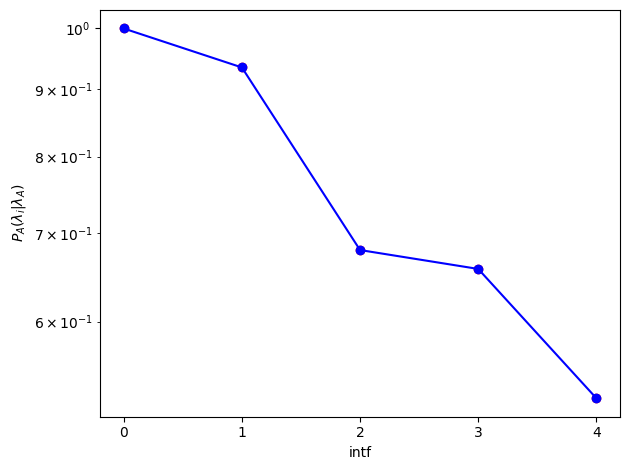

In [66]:
# Make a figure of the global crossing probabilities
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.plot(Pcrossfull, "o", c = "r")
ax.errorbar([i for i in range(len(Pcrossfull))], Pcrossfull, fmt="-o", c = "b", ecolor="r", capsize=6)


# cosdip meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.004830, Pcrossfull[2]*0.05068988646, Pcrossfull[3]*0.05189862680, Pcrossfull[4]*0.05071184896, Pcrossfull[5]*0.05083284286, Pcrossfull[6]*0.05067963543], fmt="-o", c = "b", ecolor="r", capsize=6)

# cosbump meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002535, Pcrossfull[2]*0.04393065503, Pcrossfull[3]*0.04910273500, Pcrossfull[4]*0.05239942040, Pcrossfull[5]*0.05789033634, Pcrossfull[6]*0.0614468], fmt="-o", c = "b", ecolor="r", capsize=6)

# cosbump meta true
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002629, Pcrossfull[2]*0.03973528878, Pcrossfull[3]*0.03900922030, Pcrossfull[4]*0.05239942040, Pcrossfull[5]*0.03734118282, Pcrossfull[6]*0.03899369101], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosdips
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.007239, Pcrossfull[2]*0.0414296, Pcrossfull[3]*0.0445266, Pcrossfull[4]*0.0483538], fmt="-o", c = "b", ecolor="r", capsize=6)

# 3 cosbumps
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002295, Pcrossfull[2]*0.0328798, Pcrossfull[3]*0.031594, Pcrossfull[4]*0.031474, Pcrossfull[5]*0.03080392, Pcrossfull[6]*0.0308589], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosbumps
#ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002768, Pcrossfull[2]*0.04440278, Pcrossfull[3]*0.043053, Pcrossfull[4]*0.0463156], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosbumps Langevin
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.006395, Pcrossfull[2]*0.02092401277, Pcrossfull[3]*0.01899419954, Pcrossfull[4]*0.01929952226], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat dt=0.00002 30k cycles
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.003294, Pcrossfull[2]*0.07640968, Pcrossfull[3]*0.07789262, Pcrossfull[4]*0.0812692], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat 100k cycles
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002741, Pcrossfull[2]*0.034092, Pcrossfull[3]*0.033621, Pcrossfull[4]*0.0398], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat Langevin
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.013684, Pcrossfull[2]*0.0825226801, Pcrossfull[3]*0.01027325454, Pcrossfull[4]*0.02130629112], fmt="-o", c = "b", ecolor="r", capsize=6)

ax.set_xlabel("intf")
ax.set_ylabel(r"$P_A(\lambda_i|\lambda_A)$")
ax.set_xticks(np.arange(len(interfaces)))
fig.tight_layout()
fig.show()
fig.savefig("Global_probs.pdf")

print("This should be the same as the repptis_report.pdf value:", Pcrossfull[-1])
print("which is the case!")
print("Here, the load immediately disappeared. For a simulation where this is")
print("not the case, the above code should be adapted a little bit.")

In [67]:
# TODO I am not sure what this is

# Construct lists of the local probs

# Or we can use the get_global_probz function, using lists of the local probs
# These do not use the 0- ensemble
pmps = [data[i]["full"]["LMR"] for i in range(1,len(pathensembles))]
pmms = [data[i]["full"]["LML"] for i in range(1,len(pathensembles))]
ppps = [data[i]["full"]["RMR"] for i in range(1,len(pathensembles))]
ppms = [data[i]["full"]["RML"] for i in range(1,len(pathensembles))]
a,b,c = get_global_probz(pmps, pmms, ppps, ppms)
print("This should be the same as the repptis_report.pdf value:", c[-1])

This should be the same as the repptis_report.pdf value: 0.525090186363009


# Now work with MSM

In [68]:
from tistools import construct_M
from tistools import global_cross_prob
from tistools import mfpt_to_first_last_state

from tistools import create_labels_states

In [69]:
def print_vector(g, states=None):
    if states is None:
        for i in range(len(g)):
            print("state", i, g[i])
    else:
        for i in range(len(g)):
            print("state", states[i], g[i][0])

In [70]:
print(interfaces)
N = len(interfaces)
# assert N >= 4
NS = 4*N-5
print("N", N)
print("len pmms", len(pmms))
print("NS", NS)

#labels2 = ["0+- LML","0+- LMR","0+- RML","1+- LML","1+- LMR",
#           "1+- RML", "1+- RMR", "2+- LML", "2+- LMR",
#           "2+- RML", "2+- RMR", "3+- LML", "3+- LMR",]
labels1, labels2 = create_labels_states(N)

[-0.1, 0.0, 0.1, 0.2, 0.3]
N 5
len pmms 4
NS 15


In [71]:
print("mm", pmms)
print("mp", pmps)
print("pm", ppms)
print("pp", ppps)
print("sum", np.array(pmms)+np.array(pmps))
print("sum", np.array(ppms)+np.array(ppps))
M = construct_M(pmms, pmps, ppms, ppps, N)

#Local crossing probabilities:
#pRMR = 0.34205627942625644.  #ppps
#pRML = 0.6579437205737436.   #ppms
#pLMR = 0.25316455696202533.  #pmps
#pLML = 0.7468354430379747.   #pmms

mm [0.06563366087175611, 0.2724837607982321, 0.045015005001667226, 0.26910903091117244]
mp [0.9343663391282439, 0.7275162392017679, 0.9549849949983328, 0.7308909690888276]
pm [1.0, 0.7099814175736661, 0.9538697420171989, 0.7234505973203089]
pp [0.0, 0.29001858242633394, 0.04613025798280115, 0.27654940267969114]
sum [1. 1. 1. 1.]
sum [1. 1. 1. 1.]


In [72]:
print("M")
print("shape", M.shape)
print("sum prob in rows", np.sum(M,axis=1))
print(M)
# row 8, 10, 12, 14. # counting starts from 0   not okay!!!!

M
shape (15, 15)
sum prob in rows [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.         0.06563366 0.93436634 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.27248376 0.72751624
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.04501501 0.95498499 0.         0.
  0.       

# Look at this Markov model

In [73]:
#import numpy.linalg
vals, vecs = np.linalg.eig(M)
print(vals)
vals, vecs = np.linalg.eig(M.T)
print(vals)

[ 1.00000000e+00+0.00000000e+00j -1.00000000e+00+0.00000000e+00j
  3.97559163e-01+7.03878540e-01j  3.97559163e-01-7.03878540e-01j
 -3.97559163e-01+7.03878540e-01j -3.97559163e-01-7.03878540e-01j
 -1.98536265e-17+4.83852933e-01j -1.98536265e-17-4.83852933e-01j
  1.09295039e-16+7.23873704e-09j  1.09295039e-16-7.23873704e-09j
 -8.65380466e-17+0.00000000e+00j -3.63175293e-17+0.00000000e+00j
 -5.76052045e-17+0.00000000e+00j  1.63191841e-19+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j]
[-1.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
 -3.97559163e-01+7.03878540e-01j -3.97559163e-01-7.03878540e-01j
  3.97559163e-01+7.03878540e-01j  3.97559163e-01-7.03878540e-01j
  5.11916458e-17+4.83852933e-01j  5.11916458e-17-4.83852933e-01j
  8.05912501e-09+0.00000000e+00j -8.05912500e-09+0.00000000e+00j
  2.49885227e-17+0.00000000e+00j -8.65665859e-17+0.00000000e+00j
 -3.93490155e-17+0.00000000e+00j -1.84103783e-17+1.03378910e-17j
 -1.84103783e-17-1.03378910e-17j]


In [74]:
print("what if chain propagates")
print("A[0,:]")
# check stationary behavior
A = M
for n in range(10):
    A = np.dot(A,M)
    #print(A)
    print(A[0,:])
    print(np.sum(A[0,:]))  # is 1 indeed

what if chain propagates
A[0,:]
[0.06563366 0.         0.         0.         0.25459965 0.67976669
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
1.0
[0.         0.00430778 0.06132588 0.25459965 0.         0.
 0.         0.         0.0305997  0.64916698 0.         0.
 0.         0.         0.        ]
1.0
[0.25890743 0.         0.         0.         0.01671031 0.04461558
 0.02172522 0.00887448 0.         0.         0.         0.
 0.1746967  0.47447029 0.        ]
1.0
[0.         0.01699304 0.24191439 0.03843553 0.         0.
 0.         0.         0.00240786 0.0510822  0.16663789 0.0080588
 0.         0.         0.47447029]
1.0
[0.52989886 0.         0.         0.         0.06591774 0.17599665
 0.12001934 0.04902641 0.         0.         0.         0.
 0.01591538 0.04322563 0.        ]
1.0
[0.         0.0347792  0.49511965 0.18593708 0.         0.
 0.         0.         0.01012941 0.21489364 0.0151812  0.00073418
 0.         0.         0.0

# Pcross with MSM

In [75]:
# global crossing prob
z1, z2, y1, y2 = global_cross_prob(M)
print("Z")
print_vector(z1, labels1)
print_vector(z2, labels2)
print("Y")
print_vector(y1, labels1)
print_vector(y2, labels2)
print("global crossing prob", y1[0])

Z
state 0-      0
state B       1
state 0+- LML 0.0
state 0+- LMR 0.5619746392543571
state 0+- RML 0.0
state 1+- LML 0.0
state 1+- LMR 0.7724564882166158
state 1+- RML 0.0
state 1+- RMR 0.7724564882166158
state 2+- LML 0.22402673569860707
state 2+- LMR 0.7983077509924298
state 2+- RML 0.224026735698607
state 2+- RMR 0.7983077509924298
state 3+- LML 0.25051846708873604
state 3+- LMR 1.0
Y
state 0-      0.5250901863630091
state B       0.0
state 0+- LML 0.0
state 0+- LMR 0.5619746392543571
state 0+- RML 0.0
state 1+- LML 0.0
state 1+- LMR 0.7724564882166158
state 1+- RML 0.0
state 1+- RMR 0.7724564882166158
state 2+- LML 0.22402673569860704
state 2+- LMR 0.7983077509924298
state 2+- RML 0.22402673569860704
state 2+- RMR 0.7983077509924298
state 3+- LML 0.25051846708873604
state 3+- LMR 1.0
global crossing prob [0.52509019]


# Collecting times

In [76]:
def print_all_tau(pathensembles, taumm, taump, taupm, taupp):
    # print all tau
    print(f"                  mm            mp            pm            pp")
    for i in range(len(pathensembles)):
        print(f"{i} {pathensembles[i].name}  {taumm[i]:13.1f} {taump[i]:13.1f} {taupm[i]:13.1f} {taupp[i]:13.1f}")

In [77]:
tau_mm, tau_mp, tau_pm, tau_pp = collect_tau(pathensembles)
tau1_mm, tau1_mp, tau1_pm, tau1_pp = collect_tau1(pathensembles)
tau2_mm, tau2_mp, tau2_pm, tau2_pp = collect_tau2(pathensembles)
taum_mm, taum_mp, taum_pm, taum_pp = collect_taum(pathensembles)

Collect tau
ensemble 0 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/000
ensemble 1 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/001
ensemble 2 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/002
ensemble 3 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/003
ensemble 4 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/004
Collect tau1
Collect tau2
Collect taum


In [78]:
print("tau")
print_all_tau(pathensembles, tau_mm, tau_mp, tau_pm, tau_pp)
print("\ntau1")
print_all_tau(pathensembles, tau1_mm, tau1_mp, tau1_pm, tau1_pp)
print("\ntaum")
print_all_tau(pathensembles, taum_mm, taum_mp, taum_pm, taum_pp)
print("\ntau2")
print_all_tau(pathensembles, tau2_mm, tau2_mp, tau2_pm, tau2_pp)

tau
                  mm            mp            pm            pp
0 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/000            nan           nan           nan        2804.4
1 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/001          324.4         430.6         429.1           0.0
2 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/002         3809.6        1828.8        1839.1        3850.5
3 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/003         1636.2         857.9         838.4        1626.4
4 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/langevin-gamma5/REPPTIS/004         3919.7        1813.0        1817.0        3818.9

tau1
                  mm            

In [79]:
def construct_tau_vector(N, NS, taumm, taump, taupm, taupp):
    assert N>=3
    assert NS==4*N-5
    assert len(taumm) == N
    assert len(taump) == N
    assert len(taupm) == N
    assert len(taupp) == N
    # unravel the values into one vector
    tau = np.zeros(NS)
    # [0-]
    tau[0] = taupp[0]
    # [0+-]
    tau[1] = taumm[1]
    tau[2] = taump[1]
    tau[3] = taupm[1]
    # [1+-] etc
    for i in range(1,N-2):
        tau[4*i]   = taumm[i+1]
        tau[4*i+1] = taump[i+1]
        tau[4*i+2] = taupm[i+1]
        tau[4*i+3] = taupp[i+1]
    # [(N-2)^(-1)]
    tau[-3] = taumm[-1]
    tau[-2] = taump[-1]
    # B
    tau[-1] = 0.   # whatever
    return tau

In [80]:
tau  = construct_tau_vector(N, NS, tau_mm, tau_mp, tau_pm, tau_pp)
tau1 = construct_tau_vector(N, NS, tau1_mm, tau1_mp, tau1_pm, tau1_pp)
taum = construct_tau_vector(N, NS, taum_mm, taum_mp, taum_pm, taum_pp)
tau2 = construct_tau_vector(N, NS, tau2_mm, tau2_mp, tau2_pm, tau2_pp)
tau_m = tau-tau1-tau2  # yes, this is the same thing as taum

print("tau")
print(tau)
print("\n")
print("tau1")
print(tau1)
print("taum")
print(taum)
print("tau2")
print(tau2)

print("\n")
print("tau = tau1+taum+tau2 => difference is", np.sum((tau-tau1-taum-tau2)**2))

tau
[2804.44118529  324.36180422  430.6082648   429.0639292  3809.64340133
 1828.81507732 1839.11375958 3850.54942792 1636.23555556  857.92877095
  838.35956391 1626.36705202 3919.67342342 1812.96830369    0.        ]


tau1
[  0.           0.           0.         429.05769912 503.41853035
 398.0658137  401.59786876 493.73157895 598.18518519 421.40677374
 415.57579146 596.0867052  503.84459459 402.0398968    0.        ]
taum
[2.80444119e+03 3.24361804e+02 5.52784145e-03 6.23008850e-03
 2.79722266e+03 1.02328691e+03 1.03502234e+03 2.85100320e+03
 4.07521481e+02 5.57500000e+00 6.24564959e+00 3.94274566e+02
 2.90111612e+03 1.00976974e+03 0.00000000e+00]
tau2
[  0.           0.         430.60273696   0.         509.00221185
 407.46235272 402.4935502  505.81464531 630.52888889 430.94699721
 416.53812286 636.00578035 514.71271271 401.15866581   0.        ]


tau = tau1+taum+tau2 => difference is 3.554291694563791e-26


# Compute tau for [0+]

In [81]:
g1, g2, h1, h2 = mfpt_to_first_last_state(M, tau1, tau_m, tau2) #, doprint=True)
print("G")
print_vector(g1, labels1)
print_vector(g2, labels2)
print("H")
print_vector(h1, labels1)
print_vector(h2, labels2)
print("interesting")
print(h1[0])

G
state 0-      0.0
state B       0.0
state 0+- LML 324.36180422264874
state 0+- LMR 4798.956908601271
state 0+- RML 0.006230088495556174
state 1+- LML 3306.231101064165
state 1+- LMR 4766.153897983962
state 1+- RML 1437.5221209092097
state 1+- RMR 6692.222483331239
state 2+- LML 3999.53324146436
state 2+- LMR 3304.099689542917
state 2+- RML 3384.266643544895
state 2+- RMR 3897.8580391570226
state 3+- LML 6823.787575951059
state 3+- LMR 1410.9284068921036
H
state 0-      4505.2728509820645
state B       0.0
state 0+- LML 0.0
state 0+- LMR 4798.951380759825
state 0+- RML 0.0
state 1+- LML 509.0084419341579
state 1+- LMR 3742.8669870855824
state 1+- RML 402.49978028479404
state 1+- RMR 3841.219279669912
state 2+- LML 3592.011759982879
state 2+- LMR 3298.5246895429173
state 2+- RML 3378.0209939537285
state 2+- RMR 3503.583472683034
state 3+- LML 3922.6714598349427
state 3+- LMR 401.15866580668944
interesting
[4505.27285098]


In [82]:
print(h1[0][0])

4505.2728509820645


# Flux

In [83]:
flux = 1/(tau[0]+h1[0][0])
dt = 0.0002
flux
print(flux/dt, "1/time")

0.684021286631258 1/time
